In [1]:
import os
import numpy as np
import pandas as pd
import skimage.io as skio
import skimage.measure as skim
import skimage.transform as skit

import p2pspatial

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-01-15 16:43:23,001 [pulse2percept] [INFO] Welcome to pulse2percept


# Idea

Compare predicted phosphene (`img_pred`) to ground truth (`img_true`):
1. Center phosphenes in the image
2. Scale the predicted phosphene so it has the same area as the ground truth (using 0-th order image moment)
3. Rotate the predicted phosphene so it has the greatest area overlap with the ground truth (using dice coefficient)

Loss function:
- Discard translation required to center phosphenes
- `loss_scale`: Measure scaling factor needed to make both phosphenes equal-sized:
    - Should be symmetric around 1 and scaled to [0, 1]: A scaling factor of 0.5 should give the same loss as a scaling factor of 2.0
        - `loss_scale = np.maximum(area_true/area_pred, area_pred/area_true) - 1`
        - `loss_scale = np.minimum(10, loss_scale) / 10`
- `loss_rot`: Measure rotation angle needed to achieve greatest overlap:
    - Should be measured as a deviation from zero, confined to [0, 1]:
        - `loss_rot = np.abs(min_rot_deg) / 180`
- `loss_dice`: Measure 1 - dice coefficient, confined to [0, 1]:
        - `loss_dice = 1 - dice_coeff`

Then the sum loss is in [0, 3]:
```
    loss = loss_scale + loss_rot + loss_dice
```

# Load data

In [2]:
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')
X, y = p2pspatial.load_data(rootfolder, subject='12-005', electrodes=['E03'], amplitude=2.0)
X.shape

(10, 9)

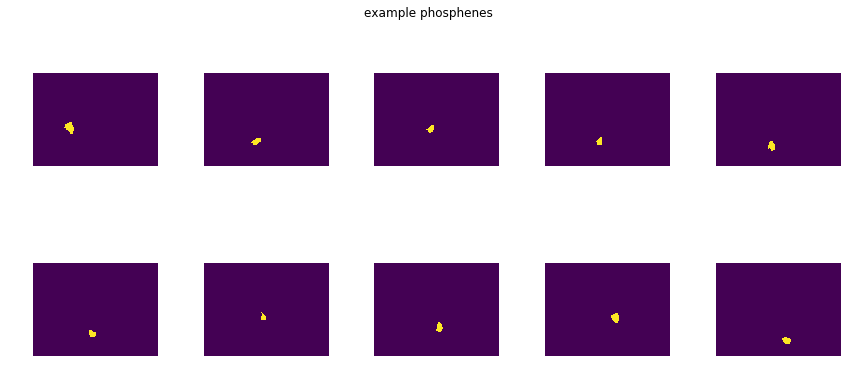

In [3]:
ncols = np.minimum(5, len(X))
nrows = int(np.ceil(len(X) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 3))
for ax, Xrow in zip(axes.ravel(), X.iterrows()):
    _, row = Xrow
    ax.imshow(skio.imread(os.path.join(row['folder'], row['filename'])))
    ax.axis('image')
    ax.axis('off')
fig.suptitle('example phosphenes')
fig.tight_layout()

# Step 1: Center and scale phosphene

1a. Center both phosphenes in the image

1b. Scale the predicted phosphene so that it has the same area (`m[0, 0]`) of ground-truth phosphene

In [4]:
def center_phosphene(img_in):
    """Centers a phosphene in an image"""
    # Subtract center of mass from image center
    m = skim.moments(img_in, order=1)
    transl = (img_in.shape[1] // 2 - m[1, 0] / m[0, 0],
              img_in.shape[0] // 2 - m[0, 1] / m[0, 0])
    return skit.warp(img_in, skit.SimilarityTransform(translation=transl).inverse)

In [5]:
def center_scale_phosphene(img_truth, img_pred):
    """Center and scale a phosphene in `img_pred` to the size of `img_truth`"""
    assert np.allclose(img_truth.shape, img_pred.shape)
    img_truth = center_phosphene(img_truth)
    img_pred = center_phosphene(img_pred)
    
    # Scale phosphene in `img_pred` to area of phosphene in `img_truth`
    area_truth = skim.moments(img_truth, order=0)[0, 0]
    area_pred = skim.moments(img_pred, order=0)[0, 0]
    scale = area_truth / area_pred

    # Shift the phosphene to (0, 0), scale, shift back to the image center
    shift_y, shift_x = np.array(img_pred.shape[:2]) / 2.0
    tf_shift = skit.SimilarityTransform(translation=[-shift_x, -shift_y])
    tf_scale = skit.SimilarityTransform(scale=scale)
    tf_shift_inv = skit.SimilarityTransform(translation=[shift_x, shift_y])
    return skit.warp(img_pred, (tf_shift + (tf_scale + tf_shift_inv)).inverse)

In [6]:
img0 = skio.imread(os.path.join(X.loc[0, 'folder'], X.loc[0, 'filename']))
img1 = skio.imread(os.path.join(X.loc[1, 'folder'], X.loc[1, 'filename']))

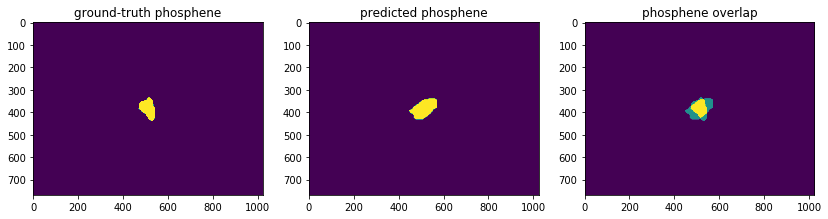

In [7]:
# pretend `img0` is the ground-truth phosphene
img_true = center_phosphene(img0)

# pretend `img1` is the predicted phosphene
img_pred = center_scale_phosphene(img0, img1)

plt.figure(figsize=(14, 6))
plt.subplot(131)
plt.imshow(img_true)
plt.title('ground-truth phosphene')

plt.subplot(132)
plt.imshow(img_pred)
plt.title('predicted phosphene')

plt.subplot(133)
plt.imshow(img_true + img_pred)
plt.title('phosphene overlap')

# Step 2: Find best rotation using dice coefficient

Now that both phosphenes are centered and have the same area, find the rotation angle that gives the best phosphene overlap (measured with the dice coefficient).

In [8]:
def dice_coeff(img0, img1):
    """Compute dice coefficient"""
    img0 = img0 > 0
    img1 = img1 > 0
    return 2 * np.sum(img0 * img1) / (np.sum(img0) + np.sum(img1))

(-90.0, 0.76310018903591681)

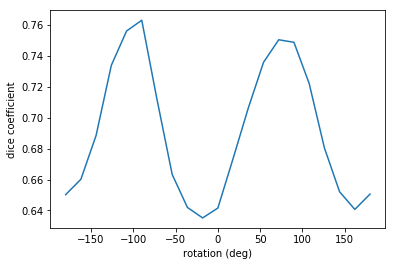

In [9]:
rot = np.linspace(-180, 180, 21)
dice = [dice_coeff(img_true, skit.rotate(img_pred, r)) for r in rot]
plt.plot(rot, dice)
plt.xlabel('rotation (deg)')
plt.ylabel('dice coefficient')
rot[np.argmax(dice)], np.max(dice)

It's possible to get multiple angles with the same max dice coefficient: Choose the smallest rotation angle.

In [10]:
print('Best angle:', np.abs(rot[np.isclose(dice, np.max(dice))]).min(), 'deg')

Best angle: 90.0 deg


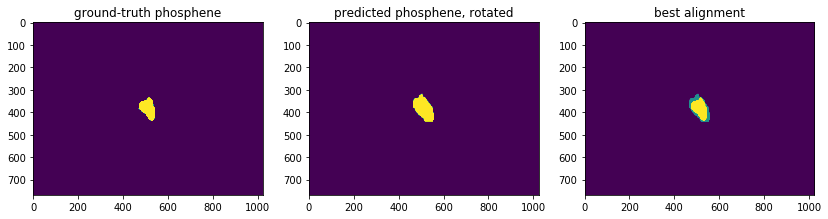

In [11]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plt.imshow(img_true)
plt.title('ground-truth phosphene')
plt.subplot(132)
plt.title('predicted phosphene, rotated')
plt.imshow(skit.rotate(img_pred, rot[np.argmax(dice)]))
plt.subplot(133)
plt.title('best alignment')
plt.imshow(img_true + skit.rotate(img_pred, rot[np.argmax(dice)]))

# Putting it all together

In [12]:
def scale_phosphene(img, scale):
    """Scales phosphene with a scaling factor"""
    # Shift the phosphene to (0, 0), scale, shift back to the image center
    shift_y, shift_x = np.array(img.shape[:2]) / 2.0
    tf_shift = skit.SimilarityTransform(translation=[-shift_x, -shift_y])
    tf_scale = skit.SimilarityTransform(scale=scale)
    tf_shift_inv = skit.SimilarityTransform(translation=[shift_x, shift_y])
    return skit.warp(img, (tf_shift + (tf_scale + tf_shift_inv)).inverse)

In [13]:
def loss(img_true, img_pred, n_angles=73):
    """Calculate loss function"""
    img_true = center_phosphene(img_true)
    img_pred = center_phosphene(img_pred)
    
    # Scale phosphene in `img_pred` to area of phosphene in `img_truth`
    area_true = skim.moments(img_true, order=0)[0, 0]
    area_pred = skim.moments(img_pred, order=0)[0, 0]
    img_pred = scale_phosphene(img_pred, area_true / area_pred)

    # Area loss: Make symmetric around 1, so that a scaling factor of 0.5 and
    # 2 both have the same loss. Bound the error in [0, 10] first, then scale
    # to [0, 1]
    loss_scale = np.maximum(area_true / area_pred, area_pred / area_true) - 1
    loss_scale = np.minimum(10, loss_scale) / 10.0

    # Rotation loss: Rotate the phosphene so that the dice coefficient is
    # maximized. If multiple angles give the same dice coefficient, choose
    # the smallest angle. Scale the loss to [0, 1]
    angles = np.linspace(-180, 180, n_angles)
    dice = [dice_coeff(img_true, skit.rotate(img_pred, r)) for r in angles]
    loss_rot = np.abs(angles[np.isclose(dice, np.max(dice))]).min() / 180.0

    # Dice loss: Turn the dice coefficient into a loss in [0, 1]
    loss_dice = 1 - np.max(dice)

    # Now all terms are in [0, 1], so loss is in [0, 3]
    return loss_scale + loss_rot + loss_dice

In [14]:
# Perfect score: zero error
loss(img0, img0)

0.0

In [15]:
# Loss for the example shown above
loss(img0, img1), loss(img1, img0)

(0.78842711735100035, 0.82568751310526334)

In [33]:
for rot in np.arange(0, 25, 5):
    print(loss(img0, skit.rotate(img0, rot)), loss(skit.rotate(img0, rot), img0))
print("still not symmetric...why?")

0.0 0.0
0.0660087688 0.0399565102409
0.0994136071121 0.0921892247284
0.149250697346 0.0956797827813
0.168826014132 0.137569380473
still not symmetric...why?


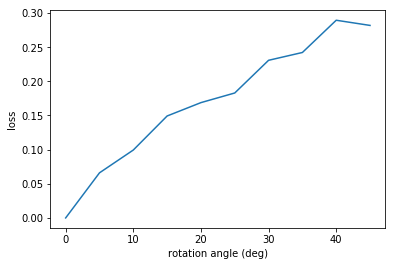

In [16]:
# Loss should increase with increasing rotation angle
angles = np.arange(0, 46, 5)
plt.plot(angles, [loss(img0, skit.rotate(img0, a)) for a in angles])
plt.xlabel('rotation angle (deg)')
plt.ylabel('loss')